In [2]:
from datetime import datetime
import os

import numpy as np
import pandas as pd
from scipy.stats import qmc
from scipy.optimize import minimize

import torch

import matplotlib.pyplot as plt
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
import matplotlib as mp
mp.rc('font', **font)

# set usetex = False if LaTex is not
# available on your system or if the
# rendering is too slow
mp.rc('text', usetex=False)

import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm

import importlib

from configs import *
import acquisition_funcs
importlib.reload(acquisition_funcs)
from acquisition_funcs import *
from objective_funcs import pythia_objective_func
import BayesOpt_utils
importlib.reload(BayesOpt_utils)
from BayesOpt_utils import *



In [3]:

PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        # 'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        # 'StringPT:sigma':[0.,1.],
        # 'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,10.0],
        'StringFlav:ProbStoUD':[0,1.0],
        'StringFlav:probQQtoQ':[0,1.0],
        # 'StringFlav:probSQtoQQ':[0,1.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,1.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]
}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    # "rFactC": 1.32,
    # "rFactB":0.855,
    # "aExtraSQuark": 0.0,
    # "aExtraDiquark":0.97,
    # "sigma":0.335,
    # "enhancedFraction":0.01,
    # "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    # "probSQtoQQ":0.915,
    # "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

param_names = list(PARAM_DICT.keys())
num_params = len(param_names)
POINT2 = {key:0.5*value for key, value in MONASH_DICT.items()}
POINT3 = {key:1.5*value for key, value in MONASH_DICT.items()}

NUM_PYTHIA_EVENTS=250000
# NUM_PYTHIA_EVENTS=1000
#250000, 1000
KERNEL = 'Matern'
NUM_TRAIN_POINTS=25
N_TRAIN_EPOCHS=100
N_BO_ITERATIONS = 70# num_params * 30
#N_BO_ITERATIONS = 2
N_OPTIMIZE_ACQ_ITER = 50
N_RESTARTS = 25
# OPTIMIZE_ACQ_METHOD: ['GD', 'Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'
KAPPA=-1E-5

num_params=6
path_name=/home/ali/Pulled_git_repositories/BayesOptPythia/BayesOpt/output/pythia_objective_func_N_BO_ITERATIONS_70_N_TRAIN_POINTS_25_N_PARAMS_6_N_OPTIMIZE_ACQ_ITER_50_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000


Text(0.5, 1.0, 'EI acquisition function')

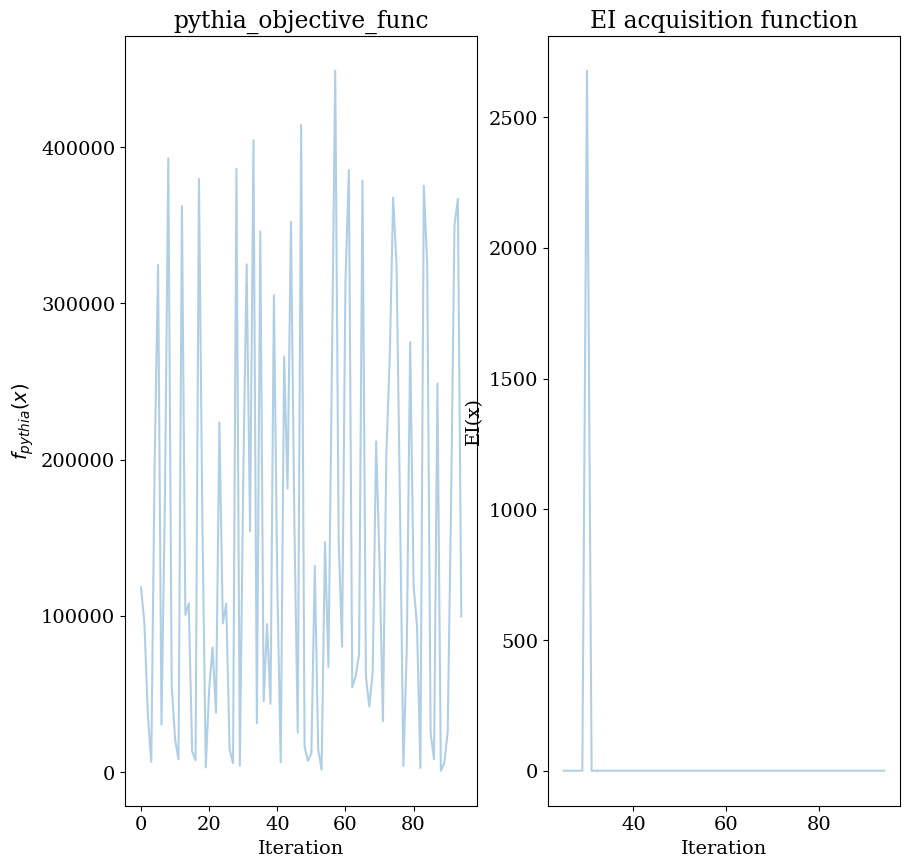

In [9]:
object_func = pythia_objective_func

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(f'num_params={num_params}')

hyper_params_dict = {
'N_BO_ITERATIONS': N_BO_ITERATIONS,
'N_TRAIN_POINTS': NUM_TRAIN_POINTS,
'N_PARAMS': num_params,
'N_OPTIMIZE_ACQ_ITER': N_OPTIMIZE_ACQ_ITER,
'N_RESTARTS': N_RESTARTS,
'KERNEL': KERNEL,
'OPTIMIZE_ACQ_METHOD': OPTIMIZE_ACQ_METHOD,
'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
}

_, config_string = configs_df(hyper_params_dict)

dir_name = directory_name(object_func, hyper_params_dict)
# print(f'dir_name={dir_name}')
path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
print(f'path_name={path_name}')
history_df = load_history_df(path_name)
iterations = np.arange(len(history_df))

fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].plot(iterations, history_df['chi2'], alpha=0.35)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(r'$f_{pythia}(x)$')
ax[0].set_title(f'{object_func.__name__}')

ax[1].plot(iterations, history_df['alpha'], alpha=0.35)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(r'EI(x)')
ax[1].set_title(f'EI acquisition function')


# PYTHIA RESUTLS TABLE

In [37]:
results_df = pd.DataFrame()
for run_ind, dirs in enumerate(os.listdir(os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output'))):
    if 'pythia' in dirs:
        path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dirs)
        hyper_params_df = pd.read_csv(os.path.join(path_name, 'configs.csv'))

        best_params_df = pd.read_csv(os.path.join(path_name, 'best_params.csv'))


        row_dict = {
            '$N_{\\text{BO}}$': hyper_params_df['N_BO_ITERATIONS'].iloc[0],
            '$N_{\\text{sobol}}$': hyper_params_df['N_TRAIN_POINTS'].iloc[0], 
            # '$N_{\\text{params}}$': hyper_params_df['N_PARAMS'].iloc[0],
            '$E_{\\text{opt}}$': hyper_params_df['N_OPTIMIZE_ACQ_ITER'].iloc[0],
            # '$N_{\\text{restarts}}$': hyper_params_df['N_RESTARTS'].iloc[0],
            # '$N_{\\text{pythia}}$': hyper_params_df['NUM_PYTHIA_EVENTS'].iloc[0],
            '$f_\\text{best}$': best_params_df['best_f'].iloc[0],
            'aLund': best_params_df['aLund'].iloc[0],
            'bLund': best_params_df['bLund'].iloc[0],
            'ProbStoUD': best_params_df['ProbStoUD'].iloc[0],
            'probQQtoQ': best_params_df['probQQtoQ'].iloc[0],
            'alphaSvalue': best_params_df['alphaSvalue'].iloc[0],
            'pTmin': best_params_df['pTmin'].iloc[0],

        }
        results_df = pd.concat([results_df, pd.DataFrame(row_dict, index=[run_ind])])
# print(results_df)
pythia_results_df = results_df.to_latex(buf=os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output','post_processing', 'pythia_results.tex'),index=False,float_format="%.4f")   
print(pythia_results_df)      

None


In [33]:
print(pythia_results_df)   

None
